## $$Sesstion-14-Project$$

This data was extracted from the census bureau database found at<br>
http://www.census.gov/ftp/pub/DES/www/welcome.html<br> Donor: Ronny Kohavi and Barry Becker,  
Data Mining and Visualization  
Silicon Graphics.  
e-mail: ronnyk@sgi.com for questions. <br>
Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).  
48842 instances, mix of continuous and discrete (train=32561, test=16281)  
45222 if instances with unknown values are removed (train=30162, test=15060) 
Duplicate or conflicting instances : 6 
Class probabilities for adult.all file  
Probability for the label '>50K' : 23.93% / 24.78% (without unknowns)  
Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns) 

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions:  

((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) Prediction task is to determine whether a person makes over 50K a year. Conversion of original data as follows:  
1. Discretized a gross income into two ranges with threshold 50,000.  
2. Convert U.S. to US to avoid periods.  
3. Convert Unknown to "?"  
4. Run MLC++ GenCVFiles to generate data,test.  

Description of fnlwgt (final weight)  
The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of  controls.  
These are:  
1. A single cell estimate of the population 16+ for each state.  
2. Controls for Hispanic Origin by age and sex.  
3. Controls by Race, age and sex.  

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. 

The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

Dataset Link 
 
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/ 
 
Problem 1: 
Prediction task is to determine whether a person makes over 50K a year. 
 
Problem 2: 
Which factors are important 
 
Problem 3: 
Which algorithms are best for this dataset 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pandas.plotting import scatter_matrix
%matplotlib inline
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Load training and test data

In [2]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)

test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None)

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
'native_country', 'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [3]:
train_set.shape,test_set.shape

((32561, 15), (16281, 15))

### View training and test data sample

In [4]:
train_set.sample(4)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
419,34,State-gov,240283,HS-grad,9,Divorced,Transport-moving,Unmarried,White,Female,0,0,40,United-States,<=50K
20662,62,Private,69867,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,55,United-States,>50K
22768,53,Local-gov,82783,HS-grad,9,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,40,United-States,<=50K
9139,25,Private,254746,Assoc-voc,11,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K


In [5]:
test_set.sample(4)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
14178,20,?,229826,Some-college,10,Never-married,?,Own-child,White,Male,0,0,25,United-States,<=50K.
14756,32,Self-emp-not-inc,29254,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,>50K.
5440,71,Private,139031,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K.
5304,35,Private,102268,12th,8,Divorced,Protective-serv,Other-relative,White,Male,0,0,40,United-States,<=50K.


### Check for null values if any  in training and test data sets

In [6]:
pd.DataFrame([train_set.isnull().sum(), test_set.isnull().sum()], index = ['train_set','test_set']).T

,train_set,test_set
age,0,0
workclass,0,0
fnlwgt,0,0
education,0,0
education_num,0,0
marital_status,0,0
occupation,0,0
relationship,0,0
race,0,0
sex,0,0


In [7]:
pd.DataFrame([train_set.dtypes, test_set.dtypes], index = ['train_set','test_set']).T

,train_set,test_set
age,int64,int64
workclass,object,object
fnlwgt,int64,int64
education,object,object
education_num,int64,int64
marital_status,object,object
occupation,object,object
relationship,object,object
race,object,object
sex,object,object


### Find the columns having data types as object

In [8]:
for i in train_set.columns:
    if train_set[i].dtypes == 'object':
        print(i)

workclass
education
marital_status
occupation
relationship
race
sex
native_country
wage_class


In [9]:
train_set.workclass.value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [10]:
pd.DataFrame([train_set.native_country.value_counts(), test_set.native_country.value_counts()], index = ['train_set','test_set']).T

,train_set,test_set
United-States,29170.0,14662.0
Mexico,643.0,308.0
?,583.0,274.0
Philippines,198.0,97.0
Germany,137.0,69.0
Canada,121.0,61.0
Puerto-Rico,114.0,70.0
El-Salvador,106.0,49.0
India,100.0,51.0
Cuba,95.0,43.0


In [11]:
train_set

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [12]:
train_set.relationship.value_counts()

 Husband           13193
 Not-in-family      8305
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: relationship, dtype: int64

### Unique counts for the features

In [13]:
train_set.workclass.nunique(),train_set.education.nunique(),train_set.marital_status.nunique(),train_set.native_country.nunique()

(9, 16, 7, 42)

### Concatenate training datasets and test datasets into a common dataframe Sample

In [14]:
X_train = train_set.copy()
X_test = test_set.copy()

In [15]:
X_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'wage_class'],
      dtype='object')

In [16]:
Sample = X_train.append(X_test)
Sample1 = Sample.drop(['native_country'], axis=1)

### Summary Statistics of Continuous Values

In [17]:
Sample.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Summary Statistics of Categorical Values

In [18]:
Sample.describe(include=['O'])

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,wage_class
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,4
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,24720


### data visualization

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


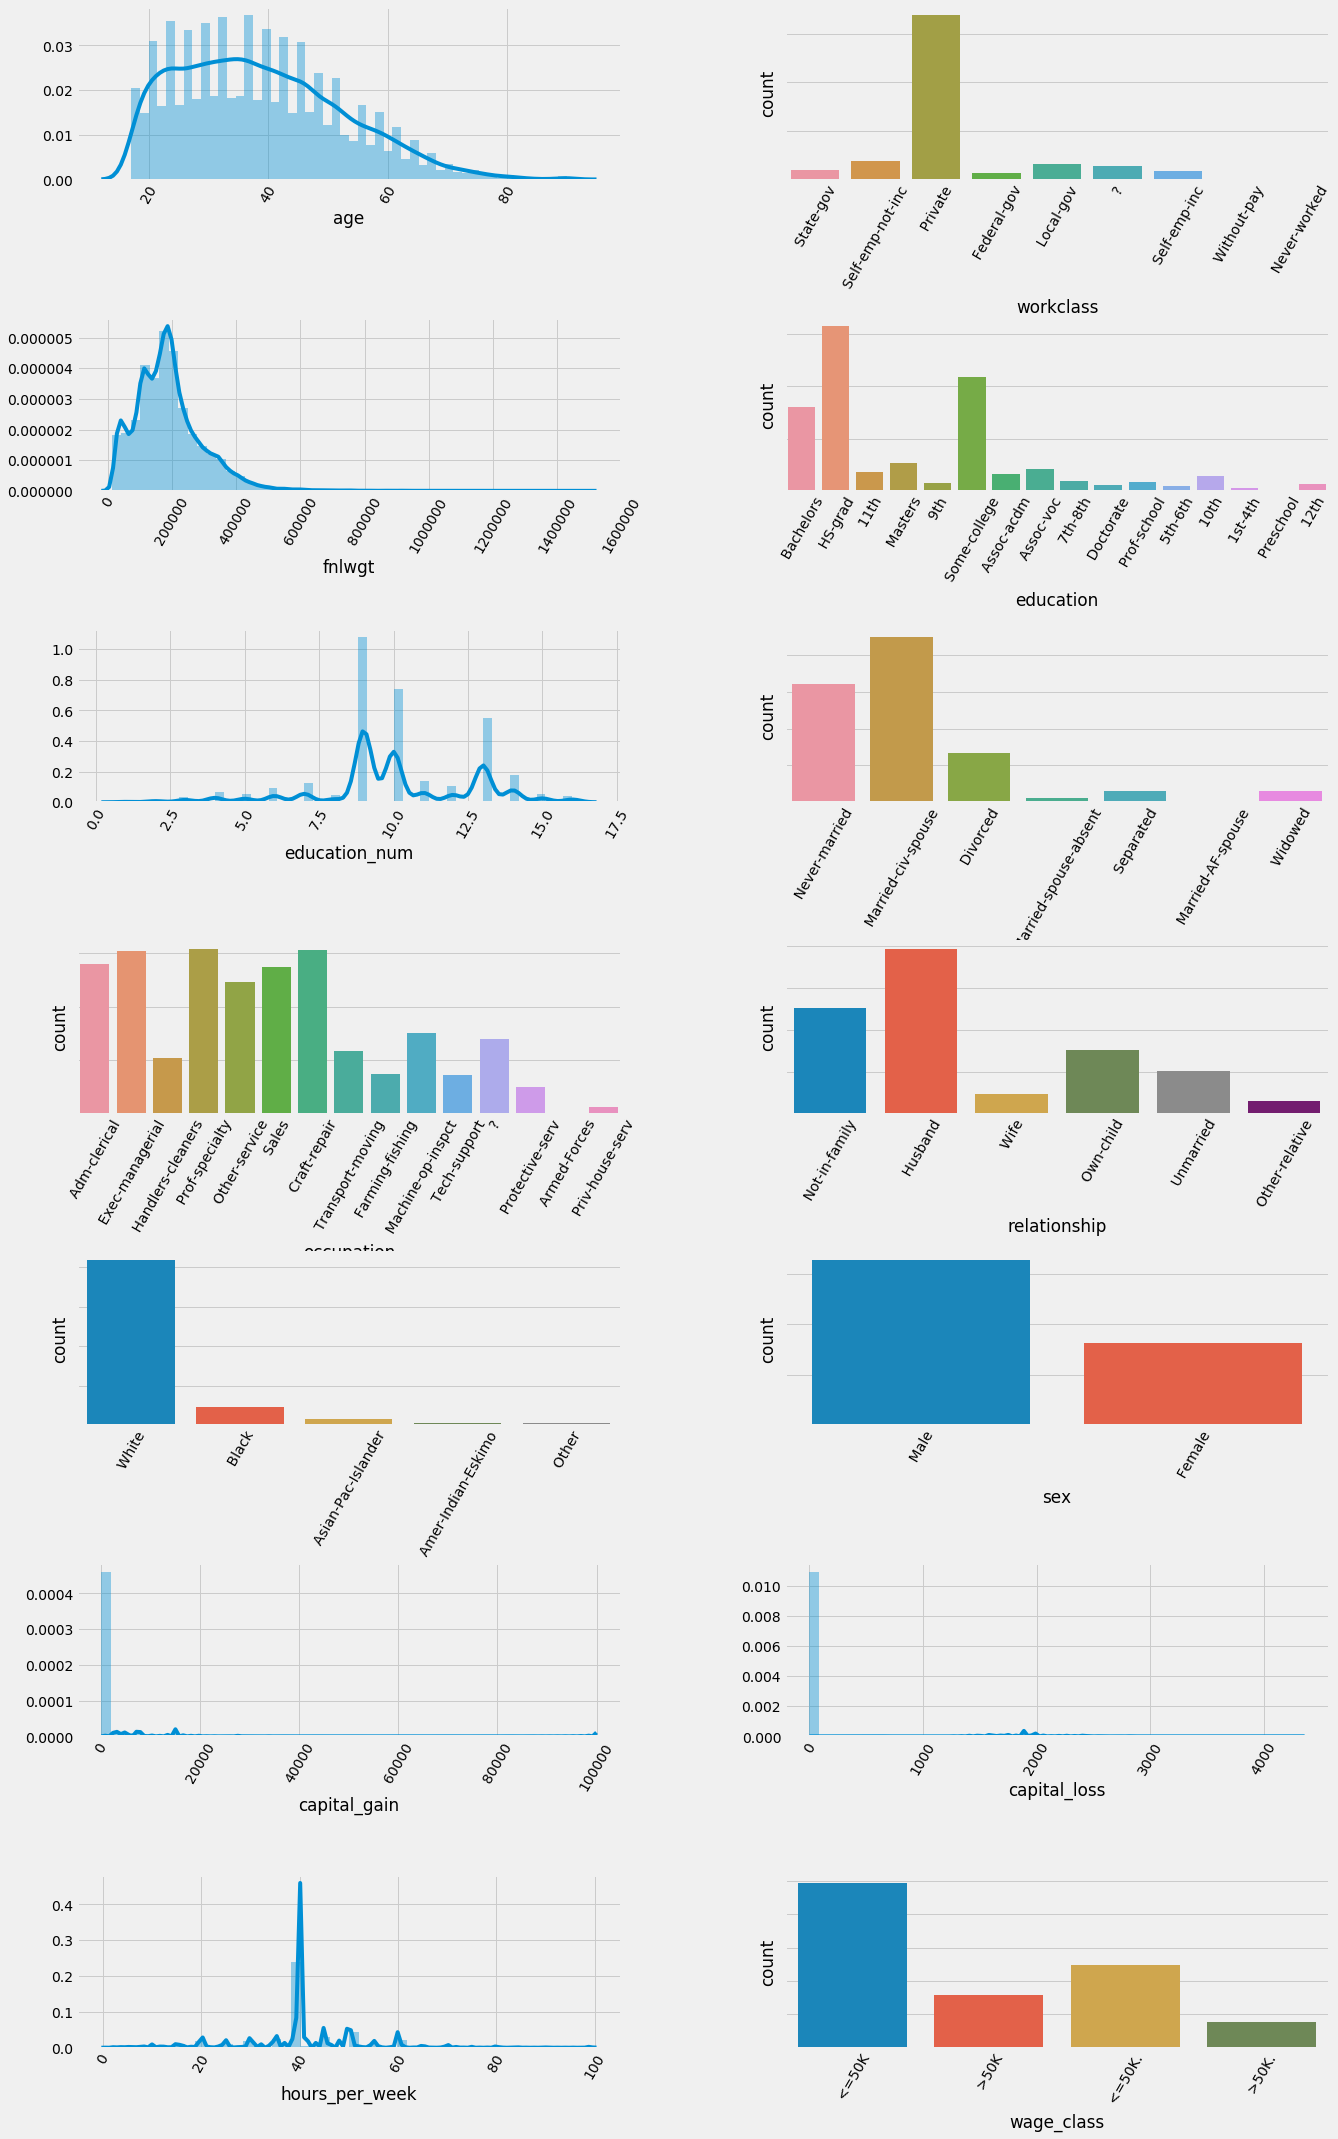

In [19]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(x=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=60)
            #plt.show()
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=60)
            #plt.show()
plot_distribution(Sample1, cols=2, width=20, height=35, hspace=0.8, wspace=0.3)

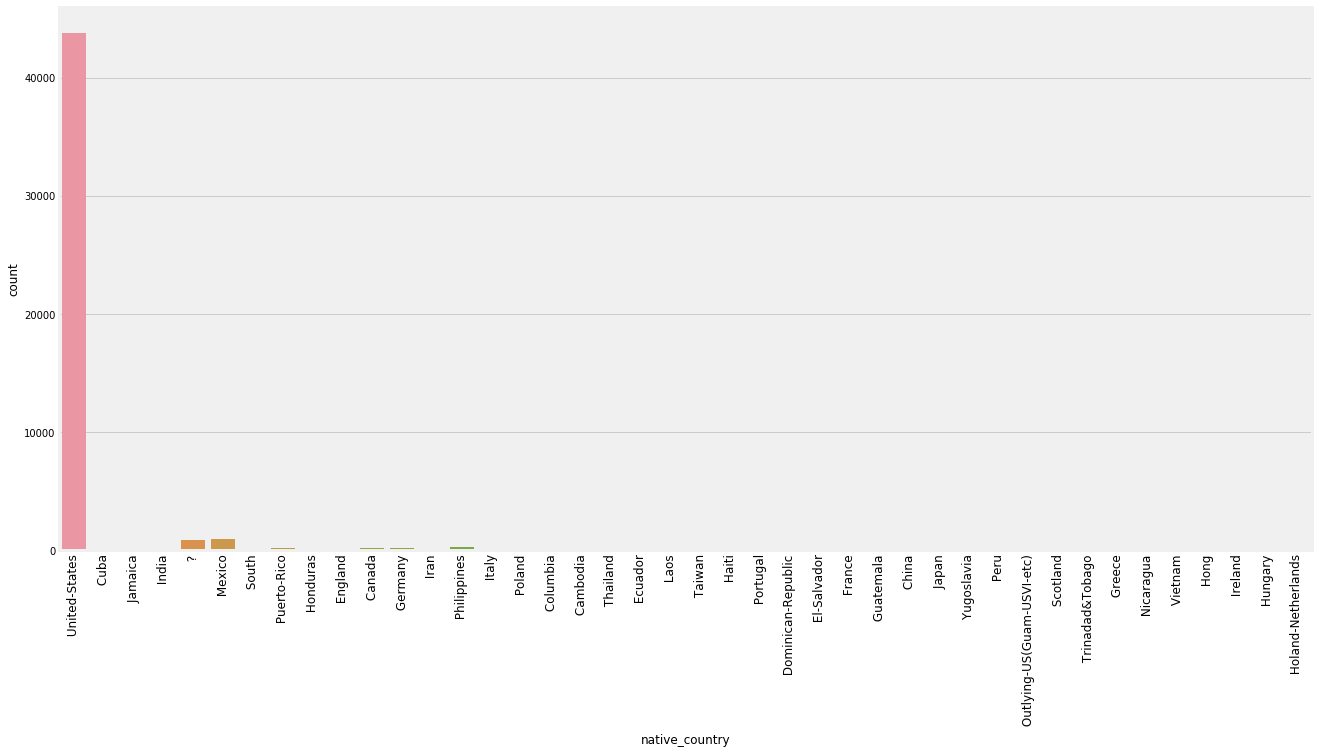

In [20]:
%matplotlib inline
plt.figure(figsize=(20,10))
g = sns.countplot(x='native_country',data=Sample)

g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 12)
plt.show()

### Eliminating irrelevant data vale ? from the triaining and test data set

In [21]:
train_set = train_set.apply(lambda x : x.replace(' ?',np.nan))
test_set = test_set.apply(lambda x : x.replace(' ?',np.nan))

In [22]:
pd.DataFrame([train_set.isnull().sum(), test_set.isnull().sum()], index = ['train_set','test_set']).T

,train_set,test_set
age,0,0
workclass,1836,963
fnlwgt,0,0
education,0,0
education_num,0,0
marital_status,0,0
occupation,1843,966
relationship,0,0
race,0,0
sex,0,0


In [23]:
test_set.dropna(inplace=True)
train_set.dropna(inplace=True)

In [24]:
pd.DataFrame([test_set.isnull().sum(), train_set.isnull().sum()], index = ['train_set','test_set']).T

,train_set,test_set
age,0,0
workclass,0,0
fnlwgt,0,0
education,0,0
education_num,0,0
marital_status,0,0
occupation,0,0
relationship,0,0
race,0,0
sex,0,0


### Converting Categorical Values to Numeric Values

In [25]:
dict_sex = {}
count = 0
for i in X_train.sex.unique():
    dict_sex[i] = count
    count +=1

dict_workclass ={}
count = 0
for i in X_train.workclass.unique():
    dict_workclass[i] = count
    count +=1
    
dict_education = {}
count = 0
for i in X_train.education.unique():
    dict_education[i] = count
    count +=1
    
dict_marital_status = {}
count = 0
for i in X_train.marital_status.unique():
    dict_marital_status[i] = count
    count +=1
    
dict_occupation = {}
count = 0
for i in X_train.occupation.unique():
    dict_occupation[i] = count
    count +=1
dict_relationship = {}
count = 0
for i in X_train.relationship.unique():
    dict_relationship[i] = count
    count +=1
dict_race = {}
count = 0
for i in X_train.race.unique():
    dict_race[i] = count
    count +=1

dict_native_country ={}
count = 0
for i in X_train.native_country.unique():
    dict_native_country[i] = count
    count +=1

dict_wage_class = {}
count = 0
for i in X_train.wage_class.unique():
    dict_wage_class[i] = count
    count +=1

In [26]:
dict_sex,dict_education,dict_wage_class,dict_native_country,dict_race,dict_occupation ,dict_marital_status

({' Male': 0, ' Female': 1},
 {' Bachelors': 0,
  ' HS-grad': 1,
  ' 11th': 2,
  ' Masters': 3,
  ' 9th': 4,
  ' Some-college': 5,
  ' Assoc-acdm': 6,
  ' Assoc-voc': 7,
  ' 7th-8th': 8,
  ' Doctorate': 9,
  ' Prof-school': 10,
  ' 5th-6th': 11,
  ' 10th': 12,
  ' 1st-4th': 13,
  ' Preschool': 14,
  ' 12th': 15},
 {' <=50K': 0, ' >50K': 1},
 {' United-States': 0,
  ' Cuba': 1,
  ' Jamaica': 2,
  ' India': 3,
  ' ?': 4,
  ' Mexico': 5,
  ' South': 6,
  ' Puerto-Rico': 7,
  ' Honduras': 8,
  ' England': 9,
  ' Canada': 10,
  ' Germany': 11,
  ' Iran': 12,
  ' Philippines': 13,
  ' Italy': 14,
  ' Poland': 15,
  ' Columbia': 16,
  ' Cambodia': 17,
  ' Thailand': 18,
  ' Ecuador': 19,
  ' Laos': 20,
  ' Taiwan': 21,
  ' Haiti': 22,
  ' Portugal': 23,
  ' Dominican-Republic': 24,
  ' El-Salvador': 25,
  ' France': 26,
  ' Guatemala': 27,
  ' China': 28,
  ' Japan': 29,
  ' Yugoslavia': 30,
  ' Peru': 31,
  ' Outlying-US(Guam-USVI-etc)': 32,
  ' Scotland': 33,
  ' Trinadad&Tobago': 34,
  ' G

In [27]:
X_train['sex'] = X_train['sex'].map(dict_sex)
X_train['education'] = X_train['education'].map(dict_education)
X_train['wage_class'] = X_train['wage_class'].map(dict_wage_class)
X_train['native_country'] = X_train['native_country'].map(dict_native_country)
X_train['race'] = X_train['race'].map(dict_race)
X_train['occupation']=X_train['occupation'].map(dict_occupation)
X_train['marital_status'] = X_train['marital_status'].map(dict_marital_status)
X_train['workclass'] = X_train['workclass'].map(dict_workclass)
X_train['relationship'] = X_train['relationship'].map(dict_relationship)

In [28]:
Xtrain = X_train.astype(int)

In [29]:
X_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,0,77516,0,13,0,0,0,0,0,2174,0,40,0,0
1,50,1,83311,0,13,1,1,1,0,0,0,0,13,0,0
2,38,2,215646,1,9,2,2,0,0,0,0,0,40,0,0
3,53,2,234721,2,7,1,2,1,1,0,0,0,40,0,0
4,28,2,338409,0,13,1,3,2,1,1,0,0,40,1,0


In [30]:
X_train.describe()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
count,32561.000000,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,2.309972,1.897784e+05,3.424465,10.080679,1.083781,4.666411,1.542397,0.221707,0.330795,1077.648844,87.303830,40.437456,1.290317,0.240810
std,13.640433,1.225728,1.055500e+05,3.453582,2.572720,1.251381,3.386119,1.437431,0.627348,0.470506,7385.292085,402.960219,12.347429,5.045373,0.427581
min,17.000000,0.000000,1.228500e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,2.000000,1.178270e+05,1.000000,9.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000
50%,37.000000,2.000000,1.783560e+05,2.000000,10.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000
75%,48.000000,2.000000,2.370510e+05,5.000000,12.000000,1.000000,7.000000,3.000000,0.000000,1.000000,0.000000,0.000000,45.000000,0.000000,0.000000
max,90.000000,8.000000,1.484705e+06,15.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,41.000000,1.000000


In [31]:
print(X_train.wage_class.value_counts())
print(X_test.wage_class.value_counts())

0    24720
1     7841
Name: wage_class, dtype: int64
 <=50K.    12435
 >50K.      3846
Name: wage_class, dtype: int64


In [32]:
dict_wage_class = {}
count = 0
for i in X_test.wage_class.unique():
    dict_wage_class[i] = count
    count +=1
    
dict_native_country ={}
count = 0
for i in X_test.native_country.unique():
    dict_native_country[i] = count
    count +=1

In [33]:
X_test['sex'] = X_test['sex'].map(dict_sex)
X_test['education'] = X_test['education'].map(dict_education)
X_test['wage_class'] = X_test['wage_class'].map(dict_wage_class)
X_test['native_country'] = X_test['native_country'].map(dict_native_country)
X_test['race'] = X_test['race'].map(dict_race)
X_test['occupation']=X_test['occupation'].map(dict_occupation)
X_test['marital_status'] = X_test['marital_status'].map(dict_marital_status)
X_test['workclass'] = X_test['workclass'].map(dict_workclass)
X_test['relationship'] = X_test['relationship'].map(dict_relationship)

In [34]:
dict_wage_class

{' <=50K.': 0, ' >50K.': 1}

In [35]:
X_test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,2,226802,2,7,0,9,3,1,0,0,0,40,0,0
1,38,2,89814,1,9,1,8,1,0,0,0,0,50,0,0
2,28,4,336951,6,12,1,12,1,0,0,0,0,40,0,1
3,44,2,160323,5,10,1,9,1,1,0,7688,0,40,0,1
4,18,5,103497,5,10,0,11,3,0,1,0,0,30,0,0


In [36]:
X_test.describe()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
count,16281.000000,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,2.315030,1.894357e+05,3.386954,10.072907,1.084270,4.731159,1.531171,0.217309,0.332965,1081.905104,87.899269,40.392236,1.219151,0.236226
std,13.849187,1.246499,1.057149e+05,3.440725,2.567545,1.269622,3.425948,1.445369,0.622232,0.471289,7583.935968,403.105286,12.479332,4.963702,0.424776
min,17.000000,0.000000,1.349200e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,2.000000,1.167360e+05,1.000000,9.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000
50%,37.000000,2.000000,1.778310e+05,2.000000,10.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000
75%,48.000000,2.000000,2.383840e+05,5.000000,12.000000,1.000000,7.000000,3.000000,0.000000,1.000000,0.000000,0.000000,45.000000,0.000000,0.000000
max,90.000000,8.000000,1.490400e+06,15.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,99999.000000,3770.000000,99.000000,40.000000,1.000000


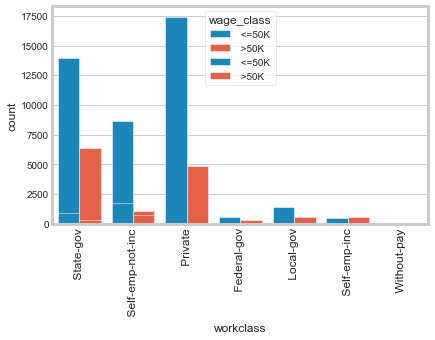

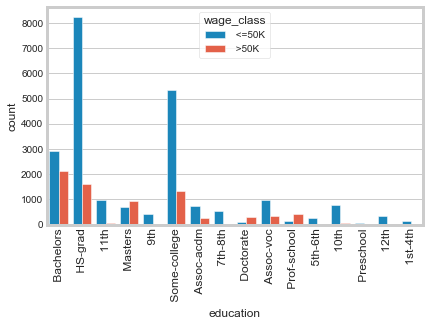

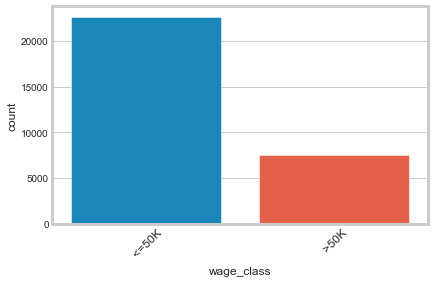

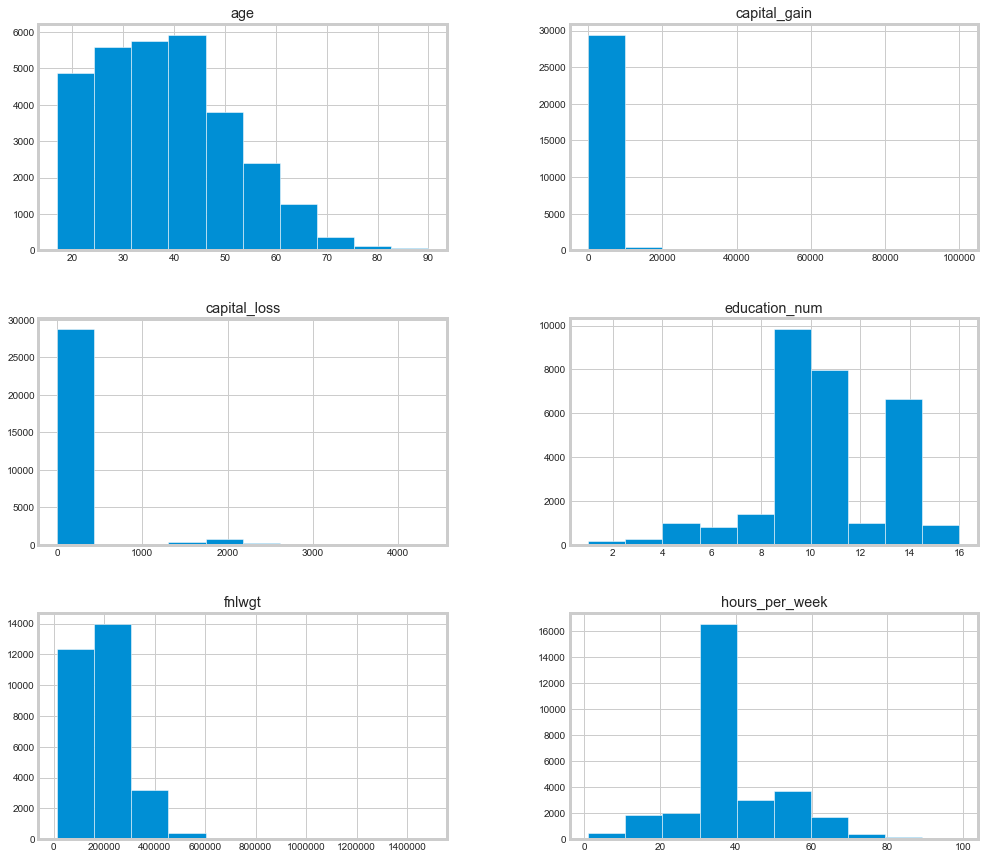

In [37]:
# Annual Income Data Analysis using Visualization

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20))
sns.set_style('whitegrid')
%matplotlib inline
sns.countplot('sex',data=train_set,hue='wage_class')

g = sns.countplot('workclass',data=train_set,hue='wage_class')
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 12)
plt.show()


g = sns.countplot('education',data=train_set,hue='wage_class')
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 12)
plt.show()

g = sns.countplot('wage_class',data=train_set)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12)
plt.show()

pd.DataFrame.hist(train_set,figsize = [15,15])
plt.show()

In [38]:
l = X_train.append(X_test)
l.wage_class.value_counts()

Features = l.drop('wage_class',axis=1)
Labels = l['wage_class']

Features.native_country.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41], dtype=int64)

### Separating the Training Label and Test Label from the the training and test Features variables

In [39]:
x_train = X_train.drop('wage_class',axis=1)
y_train = X_train['wage_class']

x_test = X_test.drop('wage_class',axis=1)
y_test = X_test['wage_class']

In [40]:
X = x_train.values
Y = y_train.values

#### Validation Features and Labels

In [41]:
Xtest = x_test.values
Ytest = y_test.values

In [42]:
x_train.shape,y_train.shape,X.shape,Y.shape,Xtest.shape,Ytest.shape

((32561, 14), (32561,), (32561, 14), (32561,), (16281, 14), (16281,))

In [43]:
Xtest

array([[    25,      2, 226802, ...,      0,     40,      0],
       [    38,      2,  89814, ...,      0,     50,      0],
       [    28,      4, 336951, ...,      0,     40,      0],
       ...,
       [    38,      2, 374983, ...,      0,     50,      0],
       [    44,      2,  83891, ...,      0,     40,      0],
       [    35,      6, 182148, ...,      0,     60,      0]], dtype=int64)

### 1. Logistic Regression

In [44]:
model_accuracy = {}
#Build the model
LR = LogisticRegression()
#traing the model 
LR.fit(X,Y)
#Model parameters study
Ypred = LR.predict(Xtest)
Ypred_proba = LR.predict_proba(Xtest)
# generate evaluation metrics
print(metrics.accuracy_score(Ytest, Ypred))
model_accuracy['Logistic Regression'] = metrics.accuracy_score(Ytest, Ypred)

0.8002579694121983


In [45]:
test_data =[]
for i in x_test.columns:
    test_data.append(x_test[i].max())
print(test_data)
test = np.array(test_data).reshape(-1,14)
print(test.shape)
print("Predicted Label \n ")
print(LR.predict(test))
print('Prediction Probabilities \n ')
print(LR.predict_proba(test))
print('coefficients = ',LR.coef_)


[90, 8, 1490400, 15, 16, 6, 14, 5, 4, 1, 99999, 3770, 99, 40]
(1, 14)
Predicted Label 
 
[1]
Prediction Probabilities 
 
[[1.26210153e-12 1.00000000e+00]]
coefficients =  [[-1.17855124e-03 -3.23172235e-03 -4.49459672e-06 -9.75476032e-03
  -1.53227112e-03 -1.74148714e-03 -1.49948632e-02 -8.22363420e-03
  -1.34589525e-03 -2.97123048e-03  3.26377525e-04  7.41454454e-04
  -5.96483783e-03 -4.26806498e-03]]


#### Evaluation of Logistic Regression Model

##### Confusion Matrix

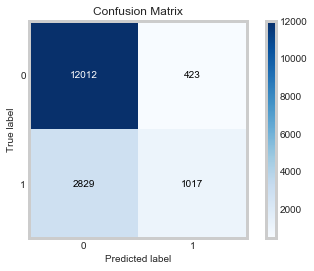

In [46]:
import scikitplot
scikitplot.metrics.plot_confusion_matrix(Ytest,Ypred)
print()

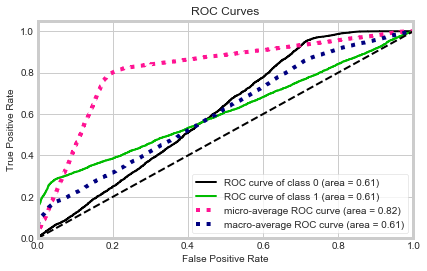

In [47]:
scikitplot.metrics.plot_roc(Ytest,Ypred_proba)

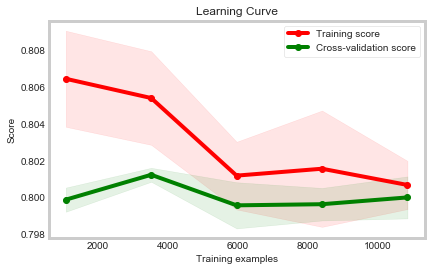

In [48]:
scikitplot.estimators.plot_learning_curve(LR,Xtest,Ytest)

In [49]:
print("ROC : ",(metrics.roc_curve(Ytest,Ypred_proba[:,1])))
print("AUC : ",(metrics.roc_auc_score(Ytest,Ypred_proba[:,1])))

ROC :  (array([0.        , 0.        , 0.        , ..., 0.99935665, 0.99935665,
       1.        ]), array([2.60010400e-04, 7.80031201e-04, 1.30005200e-03, ...,
       9.99739990e-01, 1.00000000e+00, 1.00000000e+00]), array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       1.19101487e-02, 1.08089972e-02, 8.52453975e-04]))
AUC :  0.6113904105822456


In [50]:
model_accuracy['AUC_Logistic_Regression'] = metrics.roc_auc_score(Ytest,Ypred_proba[:,1])

In [51]:
from sklearn.metrics import classification_report
print(classification_report(Ytest,Ypred))

             precision    recall  f1-score   support

          0       0.81      0.97      0.88     12435
          1       0.71      0.26      0.38      3846

avg / total       0.79      0.80      0.76     16281



#### Applying 10 Fold Cross Validation to Logistic Regression Model

In [52]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator= LogisticRegression(),     # Model to test
                X= Features,  
                y = Labels,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_accuracy['10 CV Score-Logistic Regression'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.7975435  0.79672467 0.79897646 0.80204708 0.79488229 0.80118755
 0.80405405 0.79909891 0.79582224 0.79848454]
Average accuracy:  0.7988821300510068


#### Feature Selection for Logistic Regression Model

In [53]:
from sklearn.feature_selection import RFE, RFECV
selector =  RFE(estimator=LogisticRegression(), step=1)
selector.fit(Features,Labels)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0)

In [54]:
ranks = selector.ranking_.tolist()
ranks

[2, 1, 8, 4, 1, 1, 1, 1, 1, 1, 7, 6, 3, 5]

In [55]:
df_rank = pd.DataFrame({'Feature':Features.columns,'Rank':ranks})
df_rank

,Feature,Rank
0,age,2
1,workclass,1
2,fnlwgt,8
3,education,4
4,education_num,1
5,marital_status,1
6,occupation,1
7,relationship,1
8,race,1
9,sex,1


In [56]:
#most imporatnt features

imp= df_rank.Feature[df_rank.Rank == 1]
print("The important Features in the sample data are as follows :-\n",imp.values)

The important Features in the sample data are as follows :-
 ['workclass' 'education_num' 'marital_status' 'occupation' 'relationship'
 'race' 'sex']


In [57]:
selector =  RFECV(estimator=LogisticRegression(), step=1,cv=10)
selector.fit(Features,Labels)
ranks = selector.ranking_.tolist()
df_rank_cv = pd.DataFrame({'Feature':Features.columns,'Rank':ranks})
df_rank_cv

,Feature,Rank
0,age,1
1,workclass,1
2,fnlwgt,2
3,education,1
4,education_num,1
5,marital_status,1
6,occupation,1
7,relationship,1
8,race,1
9,sex,1


In [58]:
impcv= df_rank_cv.Feature[df_rank_cv.Rank == 1]
print("The important Features in the sample data after REFCV are as follows :-\n",impcv.values)

The important Features in the sample data after REFCV are as follows :-
 ['age' 'workclass' 'education' 'education_num' 'marital_status'
 'occupation' 'relationship' 'race' 'sex' 'capital_gain' 'capital_loss'
 'hours_per_week' 'native_country']


### 2. Applying Decison Tree Classifier Model

In [59]:
#build the model
DT = DecisionTreeClassifier(random_state=0)
#train the model
DT.fit(X,Y)
#Model parameters study
Ypred = DT.predict(Xtest)
Ypred_proba = DT.predict_proba(Xtest)
# generate evaluation metrics
print("accuracy of Decision Tree Classifier :",metrics.accuracy_score(Ytest, Ypred))
#model_accuracy['Decision Tree Classifier'] = metrics.accuracy_score(Ytest, Ypred)

accuracy of Decision Tree Classifier : 0.8160432405871875


In [60]:
for depth in range(10):
    #build the model
    depth = depth + 1
    DT = DecisionTreeClassifier(max_depth=depth,random_state=0)
    #train the model
    DT.fit(X,Y)
    #Model parameters study
    Ypred = DT.predict(Xtest)
    Ypred_proba = DT.predict_proba(Xtest)
    # generate evaluation metrics
    print("accuracy of Decision Tree Classifier for max_depth ", depth," : ",metrics.accuracy_score(Ytest, Ypred))
    
    #model_accuracy[auc] = metrics.roc_auc_score(Ytest,Ypred_proba[:,1])

accuracy of Decision Tree Classifier for max_depth  1  :  0.8049259873472145
accuracy of Decision Tree Classifier for max_depth  2  :  0.8049259873472145
accuracy of Decision Tree Classifier for max_depth  3  :  0.8228610036238561
accuracy of Decision Tree Classifier for max_depth  4  :  0.8442356120631411
accuracy of Decision Tree Classifier for max_depth  5  :  0.8447884036607088
accuracy of Decision Tree Classifier for max_depth  6  :  0.8527117498925127
accuracy of Decision Tree Classifier for max_depth  7  :  0.8540015969535041
accuracy of Decision Tree Classifier for max_depth  8  :  0.8554142865917327
accuracy of Decision Tree Classifier for max_depth  9  :  0.8575026104047663
accuracy of Decision Tree Classifier for max_depth  10  :  0.8586081935999017


In [61]:
#since the model has best accuracy for max_depth 10 so retraining the model with max_depth as 10
#build the model
DT = DecisionTreeClassifier(max_depth=10,random_state=0)
#train the model
DT.fit(X,Y)
#Model parameters study
Ypred = DT.predict(Xtest)
Ypred_proba = DT.predict_proba(Xtest)
# generate evaluation metrics
print("accuracy of Decision Tree Classifier :",metrics.accuracy_score(Ytest, Ypred))
model_accuracy['Accuracy Score of Decision Tree Classifier Model'] = metrics.accuracy_score(Ytest, Ypred)
model_accuracy['AUC of Decision Tree Model Classifier - depth 10'] = metrics.roc_auc_score(Ytest,Ypred_proba[:,1])

accuracy of Decision Tree Classifier : 0.8586081935999017


#### Evaluation of the Decision Tree Model trained with max_depth as 10

#### Confusion Matrix

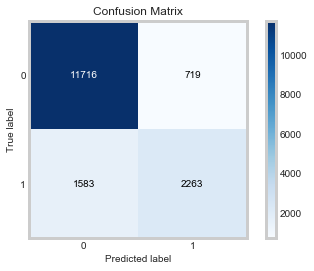

In [62]:
scikitplot.metrics.plot_confusion_matrix(Ytest,Ypred)

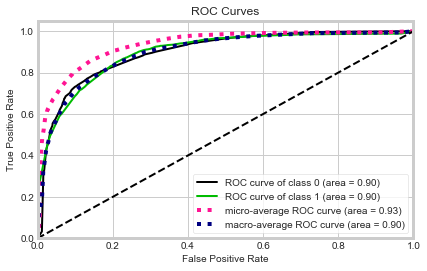

In [63]:
scikitplot.metrics.plot_roc(Ytest,Ypred_proba)

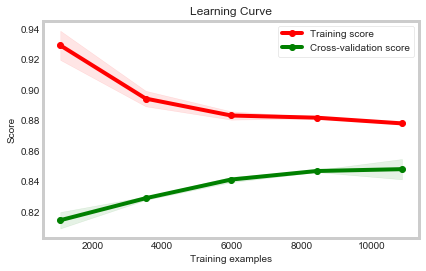

In [64]:
scikitplot.estimators.plot_learning_curve(DT,Xtest,Ytest)

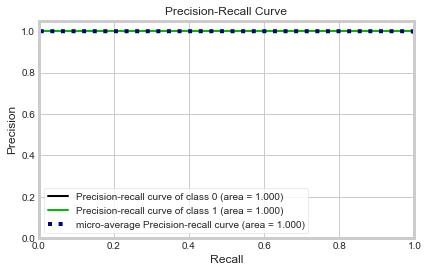

In [65]:
scikitplot.metrics.plot_precision_recall(Ypred,Ypred_proba)

#### Applying 10 Fold cross validation to DEcision Tree Classifier Model

In [66]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator= DecisionTreeClassifier(random_state=0),     # Model to test
                X= Features,  
                y = Labels,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())


Accuracy per fold: 
Cross Validation score:  [0.82006141 0.80900716 0.81453429 0.81576254 0.82006141 0.81900082
 0.81511057 0.82387876 0.80749539 0.80810977]
Average accuracy:  0.8153022124714788


In [67]:
for depth in range(12):
    depth = depth + 1
    scores = cross_val_score(estimator= DecisionTreeClassifier(max_depth=depth,random_state=0),     # Model to test
                X= Features,  
                y = Labels,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

    
    print("Average accuracy for max_depth",depth," : ", scores.mean())
    

Average accuracy for max_depth 1  :  0.8033863622153798
Average accuracy for max_depth 2  :  0.8033863622153798
Average accuracy for max_depth 3  :  0.8117204714601914
Average accuracy for max_depth 4  :  0.8436592070752982
Average accuracy for max_depth 5  :  0.8434339063910231
Average accuracy for max_depth 6  :  0.8506614044011134
Average accuracy for max_depth 7  :  0.8537938604476187
Average accuracy for max_depth 8  :  0.8550835897483091
Average accuracy for max_depth 9  :  0.8547149303740069
Average accuracy for max_depth 10  :  0.8565987329269996
Average accuracy for max_depth 11  :  0.8572333034676698
Average accuracy for max_depth 12  :  0.8572948165520635


In [68]:
scores = cross_val_score(estimator= DecisionTreeClassifier(max_depth=12,random_state=0),     # Model to test
                X= Features,  
                y = Labels,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_accuracy['10 CV Score-Decision Tree Classifier, max depth  12'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.8493347  0.8616172  0.85301945 0.85875128 0.86612078 0.85892711
 0.85749386 0.86053656 0.85091133 0.85623592]
Average accuracy:  0.8572948165520635


#### Feature Selection using REFCV for Decision Tree Classifier

In [69]:
selector =  RFECV(estimator=DecisionTreeClassifier(max_depth=12,random_state=0), step=1,cv=10)
selector.fit(Features,Labels)
ranks = selector.ranking_.tolist()
df_rank_cv = pd.DataFrame({'Feature':Features.columns,'Rank':ranks})
df_rank_cv

,Feature,Rank
0,age,2
1,workclass,6
2,fnlwgt,5
3,education,7
4,education_num,1
5,marital_status,1
6,occupation,4
7,relationship,10
8,race,11
9,sex,9


In [70]:
impcvDT= df_rank_cv.Feature[df_rank_cv.Rank == 1]
print("The important Features in the sample data after REFCV are as follows :-\n",impcvDT.values)

The important Features in the sample data after REFCV are as follows :-
 ['education_num' 'marital_status' 'capital_gain' 'capital_loss']


### 3. Applying K- Nearest Neighbor Model to sample Data

In [71]:
from sklearn.neighbors import KNeighborsClassifier

In [72]:
k = []
scores = []
errors = []
for K in range(20):
    K_value = K+1
    neigh = KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
    neigh.fit(X,Y) 
    y_pred = neigh.predict(Xtest)
    print("Accuracy is ", metrics.accuracy_score(Ytest,y_pred)*100,"% for K-Value:",K_value, " \t Error  is ", 100 - metrics.accuracy_score(Ytest,y_pred)*100,"% for K-Value:",K_value)
#     print("Error  is ", 100 - metrics.accuracy_score(Ytest,y_pred)*100,"% for K-Value:",K_value)
    k.append(K_value)
    scores.append(metrics.accuracy_score(Ytest,y_pred)*100)
    errors.append(1 - metrics.accuracy_score(Ytest,y_pred) )

Accuracy is  72.7043793378785 % for K-Value: 1  	 Error  is  27.295620662121493 % for K-Value: 1
Accuracy is  78.57011240095817 % for K-Value: 2  	 Error  is  21.429887599041834 % for K-Value: 2
Accuracy is  75.98427615011363 % for K-Value: 3  	 Error  is  24.01572384988637 % for K-Value: 3
Accuracy is  78.92635587494625 % for K-Value: 4  	 Error  is  21.073644125053747 % for K-Value: 4
Accuracy is  77.5566611387507 % for K-Value: 5  	 Error  is  22.443338861249302 % for K-Value: 5
Accuracy is  79.25188870462502 % for K-Value: 6  	 Error  is  20.748111295374983 % for K-Value: 6
Accuracy is  78.44112769485903 % for K-Value: 7  	 Error  is  21.558872305140966 % for K-Value: 7
Accuracy is  79.51600024568516 % for K-Value: 8  	 Error  is  20.483999754314837 % for K-Value: 8
Accuracy is  78.99391929242675 % for K-Value: 9  	 Error  is  21.006080707573247 % for K-Value: 9
Accuracy is  79.80468030219274 % for K-Value: 10  	 Error  is  20.195319697807264 % for K-Value: 10
Accuracy is  79.48528

Text(0.5,1,'K Value vs Accuracy')

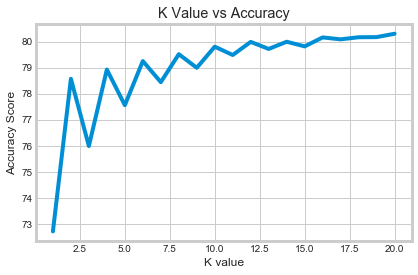

In [73]:
plt.plot(k,scores)
plt.xlabel('K value')
plt.ylabel('Accuracy Score')
plt.title('K Value vs Accuracy')

Text(0.5,1,'K Value vs errors')

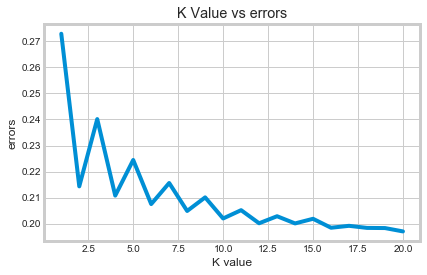

In [74]:
plt.plot(k,errors)
plt.xlabel('K value')
plt.ylabel('errors')
plt.title('K Value vs errors')

In [75]:
knn = KNeighborsClassifier(n_neighbors = 20, weights='uniform', algorithm='auto')
knn.fit(X,Y)
Ypred = knn.predict(Xtest)
Ypred_proba = knn.predict_proba(Xtest)
# generate evaluation metrics
print("accuracy of KNN Classifier :",metrics.accuracy_score(Ytest, Ypred))
model_accuracy['Accuracy Score of KNN Classifier neigbors-20'] = metrics.accuracy_score(Ytest, Ypred)

model_accuracy['AUC of KNN Classifier neighbors-20'] = metrics.roc_auc_score(Ytest,Ypred_proba[:,1])

accuracy of KNN Classifier : 0.8030219274000369


#### Evaluation of K Nearest Neighbor for K = 20

##### Confusion Matrix

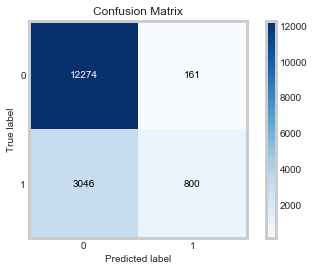

In [76]:
scikitplot.metrics.plot_confusion_matrix(Ytest,Ypred)

#### Receiver operating characteristic curve

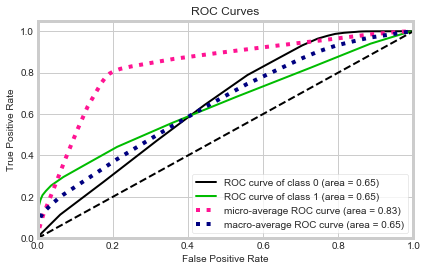

In [77]:
scikitplot.metrics.plot_roc(Ytest,Ypred_proba)

#### Learning Curve of KNN Classifier Model

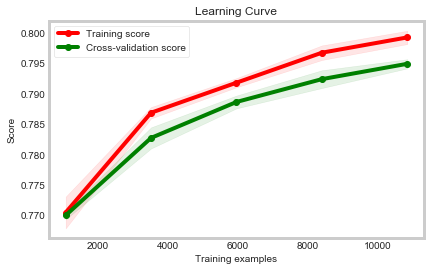

In [78]:
scikitplot.estimators.plot_learning_curve(knn,Xtest,Ytest)

#### 10 Fold Cross Validation applied to K nearest neighbor model

In [79]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(estimator= KNeighborsClassifier(n_neighbors = 20, weights='uniform', algorithm='auto'),     # Model to test
                X= Features,  
                y = Labels,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_accuracy['10 CV Score-KNN Classifier neighbors-20'] = scores.mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy per fold: 
Cross Validation score:  [0.80143296 0.80225179 0.80429887 0.80266121 0.79959058 0.7993448
 0.8046683  0.80032767 0.79746058 0.79930371]
Average accuracy:  0.8011340470216448


### 4. Ensemble model  bagging technique

##### Bagging with Logistic Regression 

Predictions :  [0 0 0 ... 0 1 0]
Prediction Probabilities :  [[0.80516775 0.19483225]
 [0.72531007 0.27468993]
 [0.8729485  0.1270515 ]
 ...
 [0.8873651  0.1126349 ]
 [0.27172553 0.72827447]
 [0.79275754 0.20724246]]
Accuracy Score of Bagging for single Logistic Regression Model : 0.8001965481235797


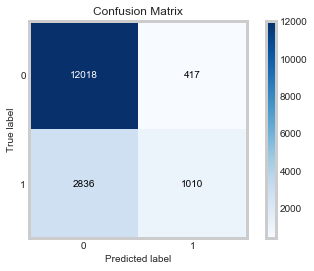

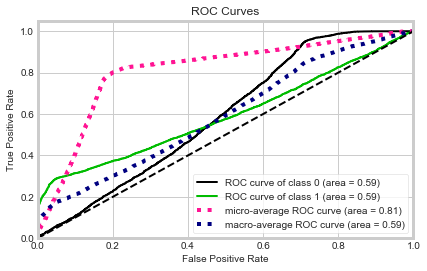

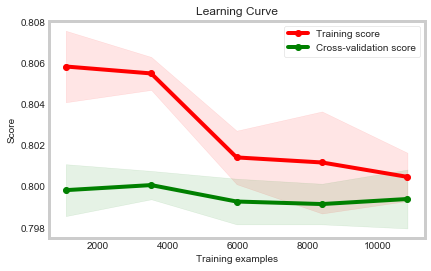

In [80]:
from sklearn.ensemble import BaggingClassifier
import scikitplot
bag_LR = BaggingClassifier(LogisticRegression(),
                            n_estimators=10, max_samples=0.5,
                            bootstrap=True, random_state=3) 

bag_LR.fit(X,Y)
#### Predictions by the Bagging Ensemble model
bag_preds = bag_LR.predict(Xtest)
print("Predictions : ",bag_preds)
bag_preds_proba = bag_LR.predict_proba(Xtest)
print("Prediction Probabilities : ",bag_preds_proba)
#### Score of the bagging ensemble model
bag_LR.score(Xtest,Ytest)
print("Accuracy Score of Bagging for single Logistic Regression Model :",metrics.accuracy_score(Ytest,bag_preds))
#### Confusion Matrix
scikitplot.metrics.plot_confusion_matrix(Ytest,bag_preds)
#### ROC
scikitplot.metrics.plot_roc(Ytest,bag_preds_proba)
model_accuracy['Accuracy Score-Bagging-Logistic Regression'] = metrics.accuracy_score(Ytest,bag_preds)
model_accuracy['AUC-Bagging-Logistic Regression'] = metrics.roc_auc_score(Ytest,bag_preds_proba[:,1])

scikitplot.estimators.plot_learning_curve(bag_LR,Xtest,Ytest)

### 5.  Bagging with KNN Model

Predictions :  [0 0 0 ... 0 0 0]
Prediction Probabilities :  [[0.675 0.325]
 [0.73  0.27 ]
 [0.855 0.145]
 ...
 [0.815 0.185]
 [0.53  0.47 ]
 [0.865 0.135]]
Accuracy Score of Bagging for single KNN Model : 0.7990295436398256


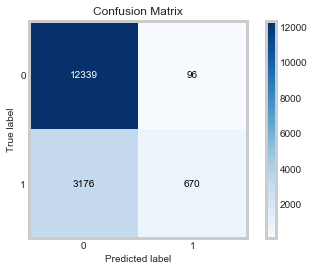

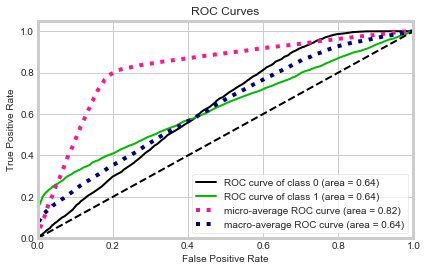

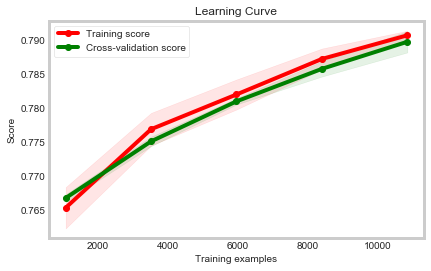

In [81]:
from sklearn.ensemble import BaggingClassifier
bag_KNN = BaggingClassifier(KNeighborsClassifier(n_neighbors = 20, weights='uniform', algorithm='auto'),
                            n_estimators=10, max_samples=0.5,
                            bootstrap=True, random_state=3) 

bag_KNN.fit(X,Y)

#### Predictions by the Bagging Ensemble model

bag_preds = bag_KNN.predict(Xtest)
print("Predictions : ",bag_preds)

bag_preds_proba = bag_KNN.predict_proba(Xtest)
print("Prediction Probabilities : ",bag_preds_proba)

#### Score of the bagging ensemble model

bag_KNN.score(Xtest,Ytest)

print("Accuracy Score of Bagging for single KNN Model :",metrics.accuracy_score(Ytest,bag_preds))

#### Confusion Matrix

scikitplot.metrics.plot_confusion_matrix(Ytest,bag_preds)

#### ROC

scikitplot.metrics.plot_roc(Ytest,bag_preds_proba)
model_accuracy['Accuracy Score-Bagging-KNN neighbors -20'] = metrics.accuracy_score(Ytest,bag_preds)
model_accuracy['AUC-Bagging-KNN neighbors -20'] = metrics.roc_auc_score(Ytest,bag_preds_proba[:,1])
scikitplot.estimators.plot_learning_curve(bag_KNN,Xtest,Ytest)

### 6. RANDOM FOREST CLASSIFIER model

In [82]:
from sklearn.ensemble import  RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(X,Y)
Ypred = RF.predict(Xtest)
Ypred_proba = RF.predict_proba(Xtest)
print("accuracy of Random Forest Classifier :",metrics.accuracy_score(Ytest, Ypred))
model_accuracy['Accuracy score of Random Forest Classifier'] = metrics.accuracy_score(Ytest, Ypred)

accuracy of Random Forest Classifier : 0.8486579448436828


#### Evaluate the Random Forest Model

##### Confusion Matrix

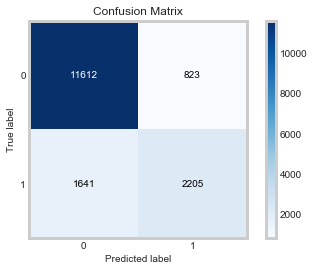

In [83]:
scikitplot.metrics.plot_confusion_matrix(Ytest,Ypred)

#### Reciver Operating Characteristic Curve for Random Forest Model

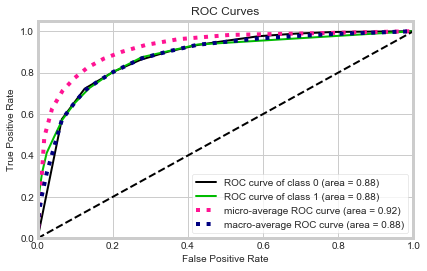

In [84]:
scikitplot.metrics.plot_roc(Ytest,Ypred_proba)

#### Learning Curve

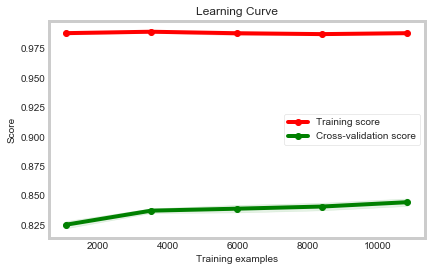

In [85]:
scikitplot.estimators.plot_learning_curve(RF,Xtest,Ytest)

In [86]:
print("AUC for Random Forest Classifier : ",metrics.roc_auc_score(Ytest,Ypred_proba[:,1]))
model_accuracy['AUC for Random Forest Classifier'] = metrics.roc_auc_score(Ytest,Ypred_proba[:,1])

AUC for Random Forest Classifier :  0.8771222525619964


#### Feature Selection using feature_importances_ parameter of Random Forest Model

In [87]:
RF.fit(Xtest, Ytest)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), RF.feature_importances_), Features.columns),reverse=True))

Features sorted by their score:
[(0.1638, 'fnlwgt'), (0.1449, 'age'), (0.1062, 'education_num'), (0.1053, 'capital_gain'), (0.0907, 'marital_status'), (0.0902, 'hours_per_week'), (0.0771, 'relationship'), (0.0698, 'occupation'), (0.0399, 'workclass'), (0.031, 'capital_loss'), (0.0307, 'education'), (0.0198, 'native_country'), (0.0168, 'sex'), (0.0138, 'race')]


#### Feature Selection using RFECV - Recursive Feature Elimination Using Cross Validation

In [88]:
selector =  RFECV(estimator=RandomForestClassifier(), step=1,cv=10)
selector.fit(Features,Labels)
ranks = selector.ranking_.tolist()
df_rank_cv = pd.DataFrame({'Feature':Features.columns,'Rank':ranks})
df_rank_cv

,Feature,Rank
0,age,1
1,workclass,1
2,fnlwgt,1
3,education,1
4,education_num,1
5,marital_status,1
6,occupation,1
7,relationship,1
8,race,2
9,sex,1


In [89]:
impcvRF= df_rank_cv.Feature[df_rank_cv.Rank == 1]
print("The important Features in the sample data after REFCV are as follows :-\n",impcvRF.values)

The important Features in the sample data after REFCV are as follows :-
 ['age' 'workclass' 'fnlwgt' 'education' 'education_num' 'marital_status'
 'occupation' 'relationship' 'sex' 'capital_gain' 'capital_loss'
 'hours_per_week' 'native_country']


#### 10 Fold Cross Validation for Random Forest Classifier

In [90]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(estimator= RandomForestClassifier(),     # Model to test
                X= Features,  
                y = Labels,      # Target variable
                scoring = "accuracy",               # Scoring metric    
                cv=10)                              # Cross validation folds

print("Accuracy per fold: ")
print("Cross Validation score: ", scores)
print("Average accuracy: ", scores.mean())
model_accuracy['10 CV Score-Random Forest Classifier'] = scores.mean()

Accuracy per fold: 
Cross Validation score:  [0.84851586 0.85486182 0.84708291 0.85588536 0.84974411 0.85012285
 0.8523751  0.84763465 0.84353881 0.84476756]
Average accuracy:  0.849452904401069


### 7. Using Boosting Method of Ensemble model to predict the annual income

In [91]:
from xgboost.sklearn import XGBClassifier
#set the parameters for the xgbosst model
params = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': 1.0,
    'silent': 1.0,
    'n_estimators': 5
}
params['eval_metric'] = ['logloss', 'auc']

#### Train the XGBClassifier model 

In [92]:
bst = XGBClassifier(**params).fit(X,Y)

#### Predict the annual income

In [93]:
preds = bst.predict(Xtest)
preds

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [94]:
preds_proba = bst.predict_proba(Xtest)
preds_proba

array([[0.9862895 , 0.01371049],
       [0.6448917 , 0.35510832],
       [0.8749048 , 0.1250952 ],
       ...,
       [0.282     , 0.718     ],
       [0.71667016, 0.28332984],
       [0.17598617, 0.8240138 ]], dtype=float32)

#### Measure the accuracy of the model

In [95]:
correct = 0
from sklearn.metrics import accuracy_score
for i in range(len(preds)):
    if (y_test[i] == preds[i]):
        correct += 1
        
acc = accuracy_score(Ytest, preds)

print('Predicted correctly: {0}/{1}'.format(correct, len(preds)))
print('Accuracy Score :{:.4f}'.format(acc))
print('Error: {0:.4f}'.format(1-acc))
model_accuracy['Accuracy Score of XGBOOST Model'] = acc

Predicted correctly: 13897/16281
Accuracy Score :0.8536
Error: 0.1464


In [96]:
from sklearn.metrics import classification_report
print(classification_report(Ytest,preds))

             precision    recall  f1-score   support

          0       0.87      0.95      0.91     12435
          1       0.76      0.55      0.64      3846

avg / total       0.85      0.85      0.85     16281



#### Confusion Matrix 

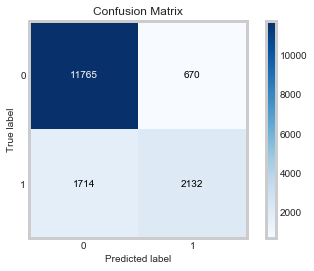

In [97]:
import scikitplot
scikitplot.metrics.plot_confusion_matrix(Ytest, preds)

#### ROC

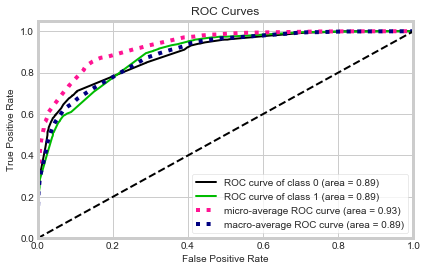

In [98]:
scikitplot.metrics.plot_roc(Ytest,preds_proba)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

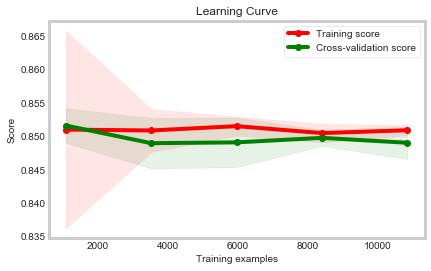

In [99]:
#### Learning Curve
scikitplot.estimators.plot_learning_curve(bst,Xtest,Ytest)

In [100]:
print('AUC for XGBOOST model : ',metrics.roc_auc_score(Ytest,preds_proba[:,1]))
model_accuracy['AUC for XGBOOST model'] = metrics.roc_auc_score(Ytest,preds_proba[:,1])

AUC for XGBOOST model :  0.8896135620253921


In [101]:
features = []
scores = []
for k,v in model_accuracy.items():
    features.append(k)
    scores.append(v)


In [102]:
df_scores = pd.DataFrame({'Features':features,'Scores':scores})
feat_cols = ['Features','Scores']
df_scores = df_scores[feat_cols]
df_scores

,Features,Scores
0,Logistic Regression,0.800258
1,AUC_Logistic_Regression,0.611390
2,10 CV Score-Logistic Regression,0.798882
3,Accuracy Score of Decision Tree Classifier Model,0.858608
4,AUC of Decision Tree Model Classifier - depth 10,0.897965
5,"10 CV Score-Decision Tree Classifier, max dept...",0.857295
6,Accuracy Score of KNN Classifier neigbors-20,0.803022
7,AUC of KNN Classifier neighbors-20,0.648625
8,10 CV Score-KNN Classifier neighbors-20,0.801134
9,Accuracy Score-Bagging-Logistic Regression,0.800197


### CONCLUSION

The important Features in the sample data are :
 'workclass' 'education_num' 'marital_status' 'occupation' 'relationship'
 'race' 'sex'
 
From the above list of Model Estimation Score, if we consider the AUC value which is evident that the Decision Tree Classifier Model and XGBOOST ensemble model have the highest accuracy for the model performance. .

AUC for Decision Tree Classifier model is 89.79% 

AUC for XGBOOST model is 88.96% 
